<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

On this page, there are different toy examples demonstrating how you can apply `glycowork` to your projects! 
Here is a summary of the different available case studies: <br>

1. [Investigation of *N*-linked and *O*-linked glycosylation in fish](#example1)
2. [Glycan binding specificities of lectins](#example2)
3. [Glycan classification using machine learning models](#example3)
4. [Constructing and exploring biosynthetic networks](#example4)
5. [Deep Learning Code Snippets](#example5)

In [ ]:
#| include: false
from nbdev.showdoc import *
from IPython.display import HTML
import pandas as pd
import copy
import warnings
warnings.filterwarnings("ignore")
from glycowork.glycan_data.loader import df_species, glycan_binding, df_glycan
from glycowork.motif.analysis import plot_embeddings, make_heatmap, characterize_monosaccharide, get_pvals_motifs
from glycowork.motif.processing import presence_to_matrix
from glycowork.motif.query import get_insight
from glycowork.ml.model_training import train_ml_model, analyze_ml_model, get_mismatch
from glycowork.ml.train_test_split import general_split
from glycowork.network.biosynthesis import construct_network, plot_network, evoprune_network, highlight_network, net_dic, network_alignment
from glycowork.network.evolution import distance_from_metric, dendrogram_from_distance

# Example 1: Investigation of *N*-linked and *O*-linked glycosylations in fish <a class="anchor" id="example1"></a>

Suppose that after investigating glycans from plants as presented in the `core` module, you are now wondering how glycans from the Actinopterygii class (ray-finned fish) look like. To satisfy your curiosity, let's start with importing the `df_species` dataset from `glycowork.glycan_data.loader` and putting a filter for animal glycans.

In [ ]:
df_animal = df_species[df_species.Class == 'Actinopterygii'].reset_index(drop = True)

In [ ]:
#| echo: false
df_animal2 = copy.deepcopy(df_animal)
df_animal2.index = df_animal2.target.values.tolist()
df_animal2.drop(['target'], axis = 1, inplace = True)
HTML(df_animal2.head().style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica','border-collapse': 'collapse','border': '1px solid black'}).render())

,Species,Genus,Family,Order,Class,Phylum,Kingdom,Domain,ref
Gal(?1-?)[Gal(?1-?)]Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Acipenser_brevirostrum,Acipenser,Acipenseridae,Acipenseriformes,Actinopterygii,Chordata,Animalia,Eukarya,https://www.frontiersin.org/articles/10.3389/fmolb.2021.778383/full
Gal(?1-?)[Gal(?1-?)]Gal(b1-4)GlcNAc(b1-2)[Gal(?1-?)[Gal(?1-?)]Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)[GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Acipenser_brevirostrum,Acipenser,Acipenseridae,Acipenseriformes,Actinopterygii,Chordata,Animalia,Eukarya,https://www.frontiersin.org/articles/10.3389/fmolb.2021.778383/full
Gal(?1-?)[Gal(?1-?)]Gal(b1-4)GlcNAc(b1-2)[GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Acipenser_oxyrinchus,Acipenser,Acipenseridae,Acipenseriformes,Actinopterygii,Chordata,Animalia,Eukarya,https://www.frontiersin.org/articles/10.3389/fmolb.2021.778383/full
Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Acipenser_oxyrinchus,Acipenser,Acipenseridae,Acipenseriformes,Actinopterygii,Chordata,Animalia,Eukarya,https://www.frontiersin.org/articles/10.3389/fmolb.2021.778383/full
Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Acipenser_oxyrinchus,Acipenser,Acipenseridae,Acipenseriformes,Actinopterygii,Chordata,Animalia,Eukarya,https://www.frontiersin.org/articles/10.3389/fmolb.2021.778383/full


To have a better overview of the glycans similarities in fish, you can plot these data using `plot_embeddings` from `glycowork.motif.analysis`. The best option here, to visualize the data, is to color the dots by taxonomic family.  

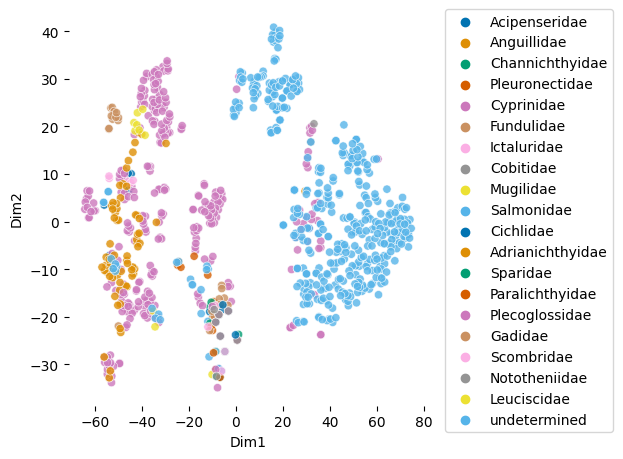

In [ ]:
plot_embeddings(df_animal.target.values.tolist(), label_list = df_animal.Family.values.tolist())

Interesting! First, the graph shows a large Salmonidae cluster in addition to maybe two elongated clusters of various families, with a large set of Cyprinidae glycans. <br> 

Now, let's focus on further analyses. We will first convert our data into a count table using `presence_to_matrix` from the `glycowork.motif.processing` module and then visualize the results. A heatmap can be generated using `make_heatmap` from `glycowork.motif.analysis`, and the `yticklabels = True` option allows us to display all the labels.

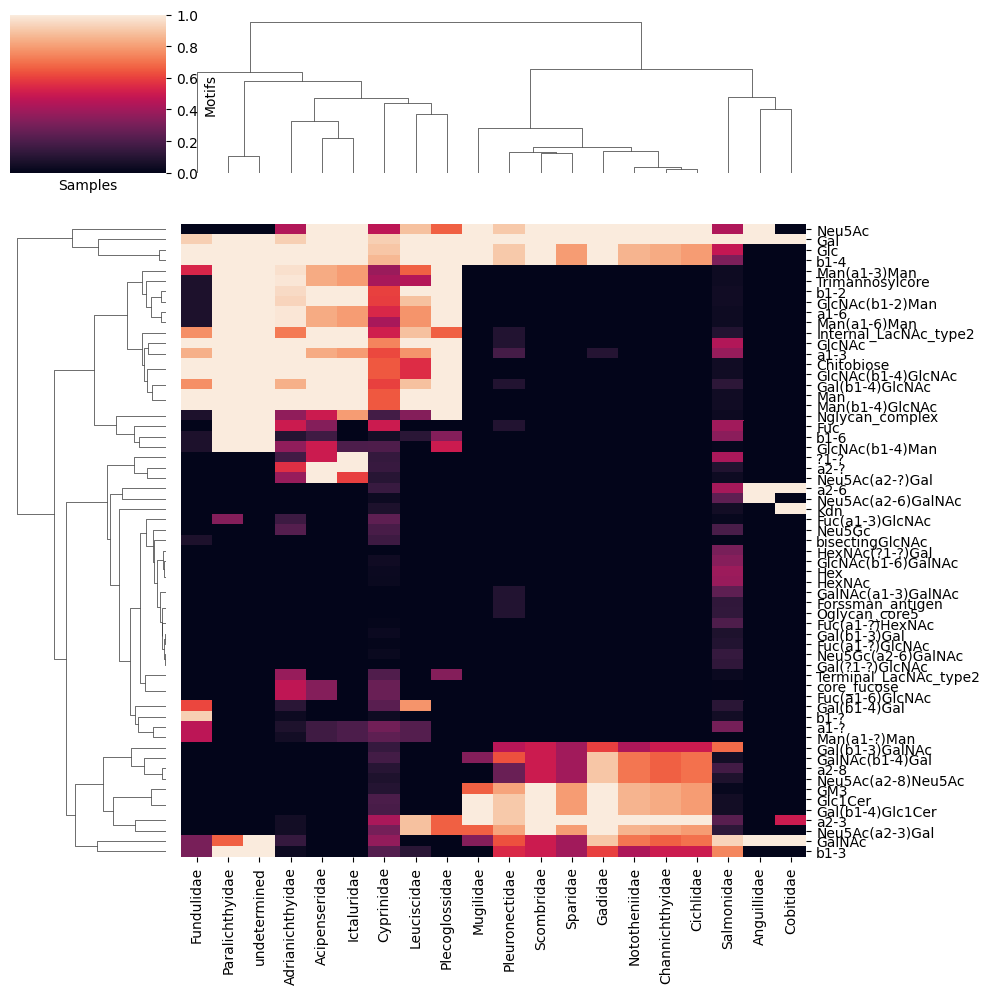

In [ ]:
df_map_animal = presence_to_matrix(df_animal, label_col_name = 'Family')
make_heatmap(df_map_animal, mode = 'motif', feature_set = ['known', 'exhaustive'], datatype = 'presence', yticklabels = True,
            estimate_speedup = True)

The first thing that catches the eye is the presence of a bunch of glycan motifs in Mugilidae to Cichlidae that are absent in the other classes. One hypothesis for this is that these families mainly contain glycosphingolipids in our database, while the other families focus on *N*-linked glycans (and Salmonidae + Cyprinidae have both as well-investigated families).<br>

To visualize which dots from the embedding plot correspond to glycosphingolipids, we can focus on Glc1Cer-containing glycans. We can map them again but with the additional option `shape_feature`. This parameter allows you to transform dots into crosses if the corresponding glycan contains the specified monosaccharide or linkage. 

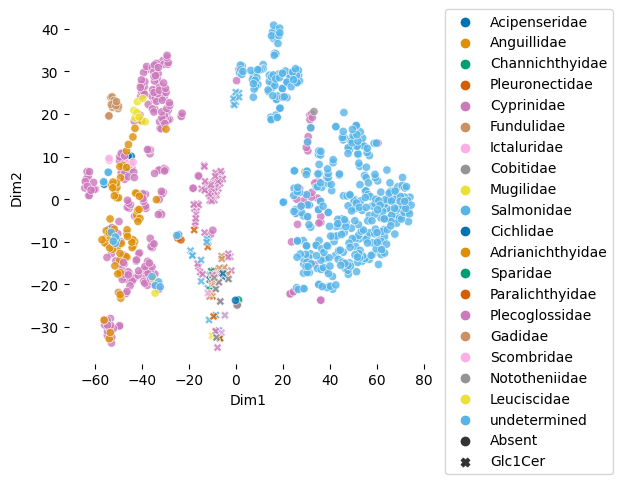

In [ ]:
plot_embeddings(df_animal.target.values.tolist(), label_list = df_animal.Family.values.tolist(), shape_feature = "Glc1Cer")

As you can see, in `df_species`, Glc1Cer-containing glycans (crosses) form a nice cluster (in the class Actinopterygii). In this class, they even constitute more isolated clusters, presumably corresponding to certain taxonomic groups. <br> 

We can also use `glycowork` to take a look at the overall monosaccharide distribution in animal glycans. The `characterize_monosaccharide` from `glycowork.motif.analysis` will be our best ally to learn what other monosaccharides, for instance, Gal variants are often connected to. <br>

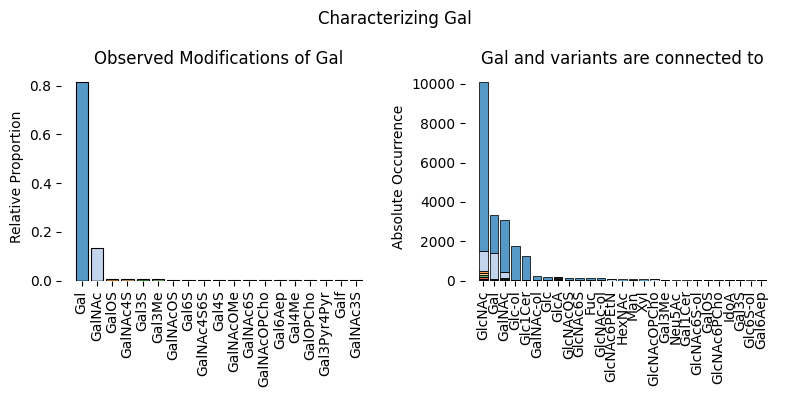

In [ ]:
characterize_monosaccharide('Gal', rank = 'Kingdom', focus = 'Animalia', modifications = True)

Running this analysis, it appears that Gal is found connected to GlcNAc as well as various other monosaccharides and that it does display several variants, including sulfurylated galactose. This is a completely different profile than we obtained for xylose in plant glycans! <br>

# Example 2: Glycan binding specificities of lectins <a class="anchor" id="example2"></a>

For this second example, we will focus on a specific set of proteins, called lectins, that bind glycans in a sequence-specific manner. One example for lectins can be found in the hemagglutinin protein of influenza virus. Influenza viruses are well known as the biological agents responsible for the seasonal flu in humans. In general, viruses penetrate inside host cells thanks to a mechanism involving contacts between proteins and glycans. Surface proteins surrounding viruses and eukaryotic cells interact together and allow the entry of viral particles inside the targeted cells. However, different influenza strains may recognize different glycosylations on proteins more or less efficiently. <br>

To measure these glycan binding specificities, one can add virus particles to glycan arrays presenting immobilized glycans. Such a protocol allows screening for specific binding. From such data, we can then ask what are the glycans that are the most efficiently recognized by a given influenza virus? <br>

Fortunately, `glycowork` can be really helpful to answer such a question! The binding specificity of 1,392 lectins for a vast range of glycans is available in the `glycan_binding` dataset. Let's start by importing these data.

In [ ]:
#| echo: false
HTML(glycan_binding.head().style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica','border-collapse': 'collapse','border': '1px solid black'}).render())

,3-Anhydro-Gal(a1-3)Gal(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal2S(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3dGal(b1-3)[Fuc(a1-4)]Glc,3dGal(b1-4)Glc,4d8dNeu5Ac(a2-3)Gal(b1-4)Glc,4dNeu5Ac(a2-3)Gal(b1-4)Glc,7dNeu5Ac(a2-3)Gal(b1-4)Glc,8dNeu5Ac(a2-3)Gal(b1-4)Glc,9dNeu5Ac(a2-3)Gal(b1-4)Glc,Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara,Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara(a1-5)Ara,Fuc(a1-2)Gal,Fuc(a1-2)Gal(b1-3)GalNAc,Fuc(a1-2)Gal(b1-3)GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)GalNAc(b1-3)Gal,Fuc(a1-2)Gal(b1-3)GalNAc(b1-3)Gal(a1-4)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GalNAc(b1-3)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GalNAc(b1-4)[Neu5Ac(a2-3)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)GalNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-6)]GalNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Fuc(a1-3)]Gal(b1-4)GlcNAc(b1-6)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc6S,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-6)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)[Fuc(a1-2)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-4)Glc6S,Fuc(a1-2)Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)GalNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-6)]GalNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-6)GalN

As you can see, this dataset contains numerical values (Z-scores) corresponding to the ability of different lectins to bind different glycans. From these data, we can compute a heatmap with `make_heatmap`. The results should teach us whether some specific strains bind specific glycans. As we work with quantitative values, the `datatype` parameter must be set to `'response'`. If you want to include literature-annotated motifs (e.g., VIM, Lewis X, Blood group A), just add 'known' to the list of the feature_set. Let's see what kind of heatmap we can generate using this dataset.

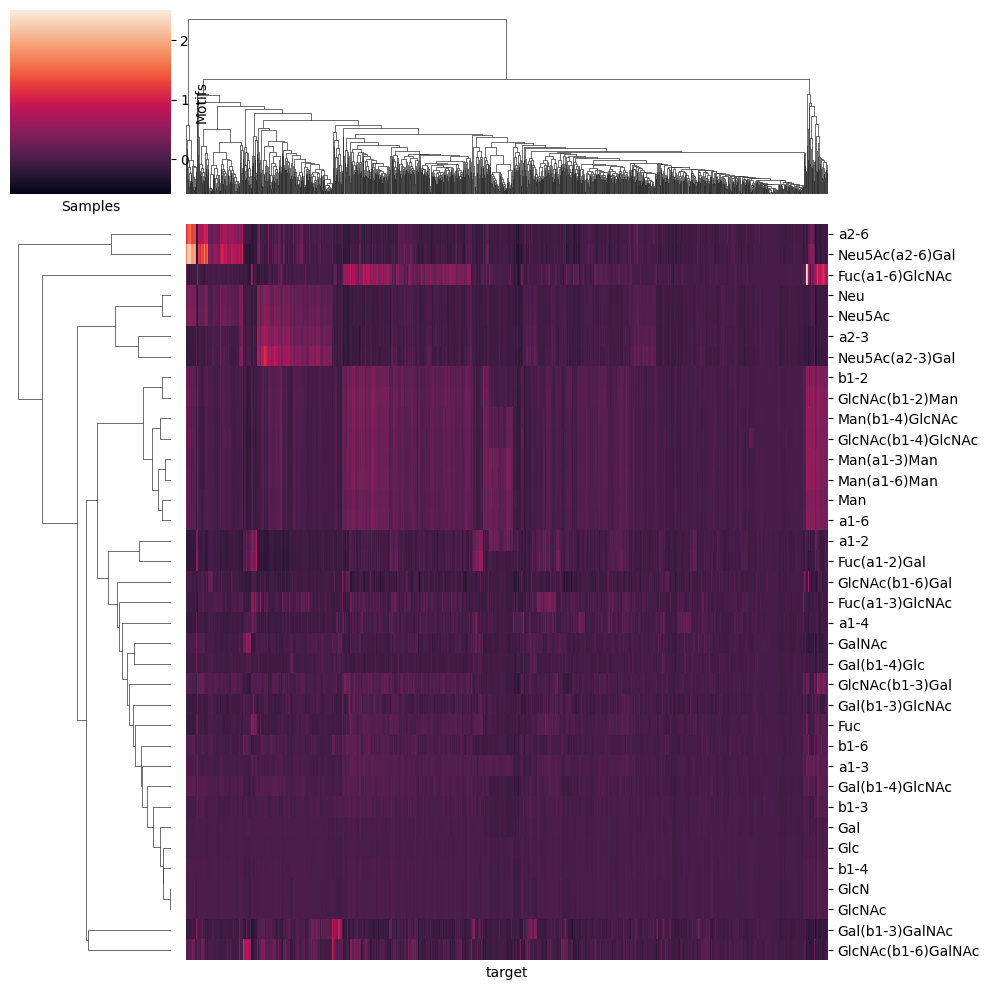

In [ ]:
make_heatmap(glycan_binding.iloc[:,:-1], mode = 'motif', feature_set = ['exhaustive'], datatype = 'response', yticklabels = 1,
            xticklabels = False)

In [ ]:
#| echo: false
import numpy as np
glycan_binding = glycan_binding.dropna(thresh = 1, axis=1).dropna(thresh = 1, axis = 0)
glycan_binding.iloc[:,:-2] = glycan_binding.iloc[:,:-2].clip(lower=0).replace(0,np.nan).astype(np.float32)

Due to the high number of lectins in this dataset, the heatmap is difficult to analyze in detail. However, we can clearly see that there are clusters of lectins recognizing specific glycan motifs. Examples include Neu5Ac(a2-6)Gal, Neu5Ac(a2-3)Gal, Fuc(a1-6)GlcNAc, and others. All these represent well-known glycan motifs with important roles in biology. <br>

Another way to analyze the glycan binding capacities of lectins is to use the `get_pvals_motifs` function from the `glycowork.motif.analysis` module. As we are working with data obtained from different proteins, we must also set `multiple_samples` to `True`.

In [ ]:
results = get_pvals_motifs(glycan_binding.iloc[:,:-1], feature_set = ['exhaustive'], multiple_samples = True)

In [ ]:
#| echo: false
results = results.applymap(str)
HTML(results[:25].style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica',
                                          'border-collapse': 'collapse','border': '1px solid black'}).render())

,motif,pval,corr_pval
59,b1-4,1.8105766142037072e-143,0.0
26,GlcN,1.7544635730381974e-120,0.0
27,GlcNAc,2.0317162129002182e-120,0.0
44,Neu5Ac,3.8759827075367294e-119,0.0
22,Glc,6.962808596175268e-111,0.0
39,Man,2.9957854425375286e-107,0.0
42,Neu,3.320484520976721e-100,0.0
67,Man(a1-3)Man,1.5247041217922468e-97,0.0
76,Man(a1-6)Man,1.2866694380055156e-94,0.0
8,Gal,6.588202471325141e-85,0.0


These results indicate, for each motif, a p-value and a corrected p-value. These quantitative results support our qualitative observations from before. However, this represents a bird's eye view across all lectins in the dataset. A follow-up analysis might be to focus on a specific group of lectins, analyzing their binding patterns in depth.

# Example 3: Glycan classification using machine learning models <a class="anchor" id="example3"></a>

The investigation of glycans from animals and viruses demonstrated how specific their presence in an organism can be. This particular characteristic can be exploited to predict the source of a given glycan among organisms. By classifying which glycans stem from which species/taxonomic groups, machine learning models can be trained to learn which motifs are enriched in which species, allowing for further insights. <br>

Let's see how we can use `glycowork` to classify vertebrate versus invertebrate glycans! First, we need to annotate each known glycan using a binary code where **1** means **vertebrate glycan** and **0** means **invertebrate glycan**. 

In [ ]:
vertebrate = [1 if k == 'Chordata' else 0 for k in df_species[df_species.Kingdom == 'Animalia'].Phylum.values.tolist()]

Now, we have to generate two sets of glycans that we will use as train set and test set. In addition, we also need their corresponding sets with classes labelled as **0** or **1**. One way to do it is to use the `general_split` function from the `glycowork.ml.train_test_split` module. This function assigns the data with a 80/20 ratio to train and test sets respectively.

In [ ]:
X_train, X_test, y_train, y_test = general_split(df_species[df_species.Kingdom == 'Animalia'].target.values.tolist(), vertebrate)

It is now time to train a machine learning model on these data! Different machine learning algorithms are available in `glycowork` and here we can use the `train_ml_model` function from the `glycowork.ml.model_training` module. This classification method uses a standard machine learning model (XGBoost) trained on short glycan motifs which may not be the most accurate, but can be sufficient for a preliminary exploration of our problem. Plus, it has the advantage of running faster than other more complex algorithms such as deep learning so... let's give it a try!

In [ ]:
model_ft, _, X_test = train_ml_model(X_train, X_test, y_train, y_test, feature_calc = True, feature_set = ['exhaustive'],
                         return_features = True)


Calculating Glycan Features...

Training model...
[10:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Evaluating model...
Accuracy of trained model on separate validation set: 0.9300567107750473


As you can see, even this (quite) simple algorithm is enough to reach around 93% prediction accuracy on the test set! It also confirms that glycan sequence is highly representative of their origin and allows to efficiently discriminate vertebrate from invertebrate glycans. <br>

One more step we can do is the analysis of the model we have generated. This is important, as we do not know yet what information is the most useful for the model to predict the origin of a glycan. The `analyze_ml_model` function can help us to understand on which basis the model predictions are made.

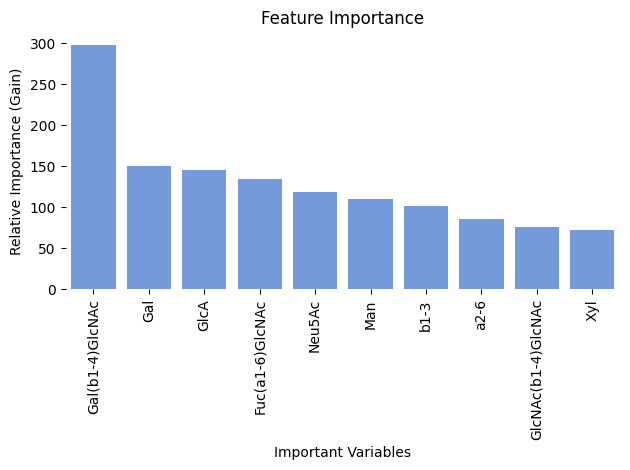

In [ ]:
analyze_ml_model(model_ft)

Interesting! It appears that the presence/absence of the Gal(b1-4)GlcNAc motif (type II LacNAc) and GlcA in glycans is quite discriminative of its belonging to the Chordata phylum or not! <br>

Next to knowing what is important for model prediction, it is often also crucial to know the limits of a model. In `glycowork`, you can use `get_mismatch` from the `glycowork.ml.model_training` module to get a sense of wrong classifications. This could for instance inform you about potential model biases.

In [ ]:
get_mismatch(model_ft, X_test, y_test)

[('Man(a1-?)Man(a1-?)[Man(a1-?)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc',
  0.7339085340499878),
 ('Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.9170841574668884),
 ('Man(a1-?)Man(a1-?)[Man(a1-?)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.8410650491714478),
 ('Man(a1-?)Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc', 0.4614127278327942),
 ('GlcNAc(b1-2)Man(a1-3)[Man(a1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.47031551599502563),
 ('Gal(a1-4)Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)]GalNAc', 0.9608173370361328),
 ('Man(a1-2)Man(a1-6)Man(a1-6)Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.4972776770591736),
 ('Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-6)]Man(a1-6)[Man(a1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.561668336391449),
 ('Man(a1-3)[Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc', 0.43283137679100037),
 ('Man(a1-2)Man(a1-6)[Man(a1-3)]Man(a1-6)[Man(a1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.6054487228393555)]

Here we can see that our model was especially confused by glycans which can occur in both phyla and therefore are ambiguous for classification ambiguous. Maybe in these scenarios a more powerful, deep learning-based model might be able to differentiate (at least a bit better)! <br>

# Constructing and exploring biosynthetic networks <a class="anchor" id="example4"></a>

The `network` module of glycowork is designed to readily construct and analyze biosynthetic networks from a list of glycans in a very modular way. Below, this is illustrated with a fictional set of milk glycans (all default parameters of `construct_network` are optimized for milk glycans and should be changed for other glycan classes). Just inputting a list of biosynthetically related glycans into `construct_network` and then `plot_network` will build and plot our biosynthetic network! (depending on your browser etc, this might not render correctly)

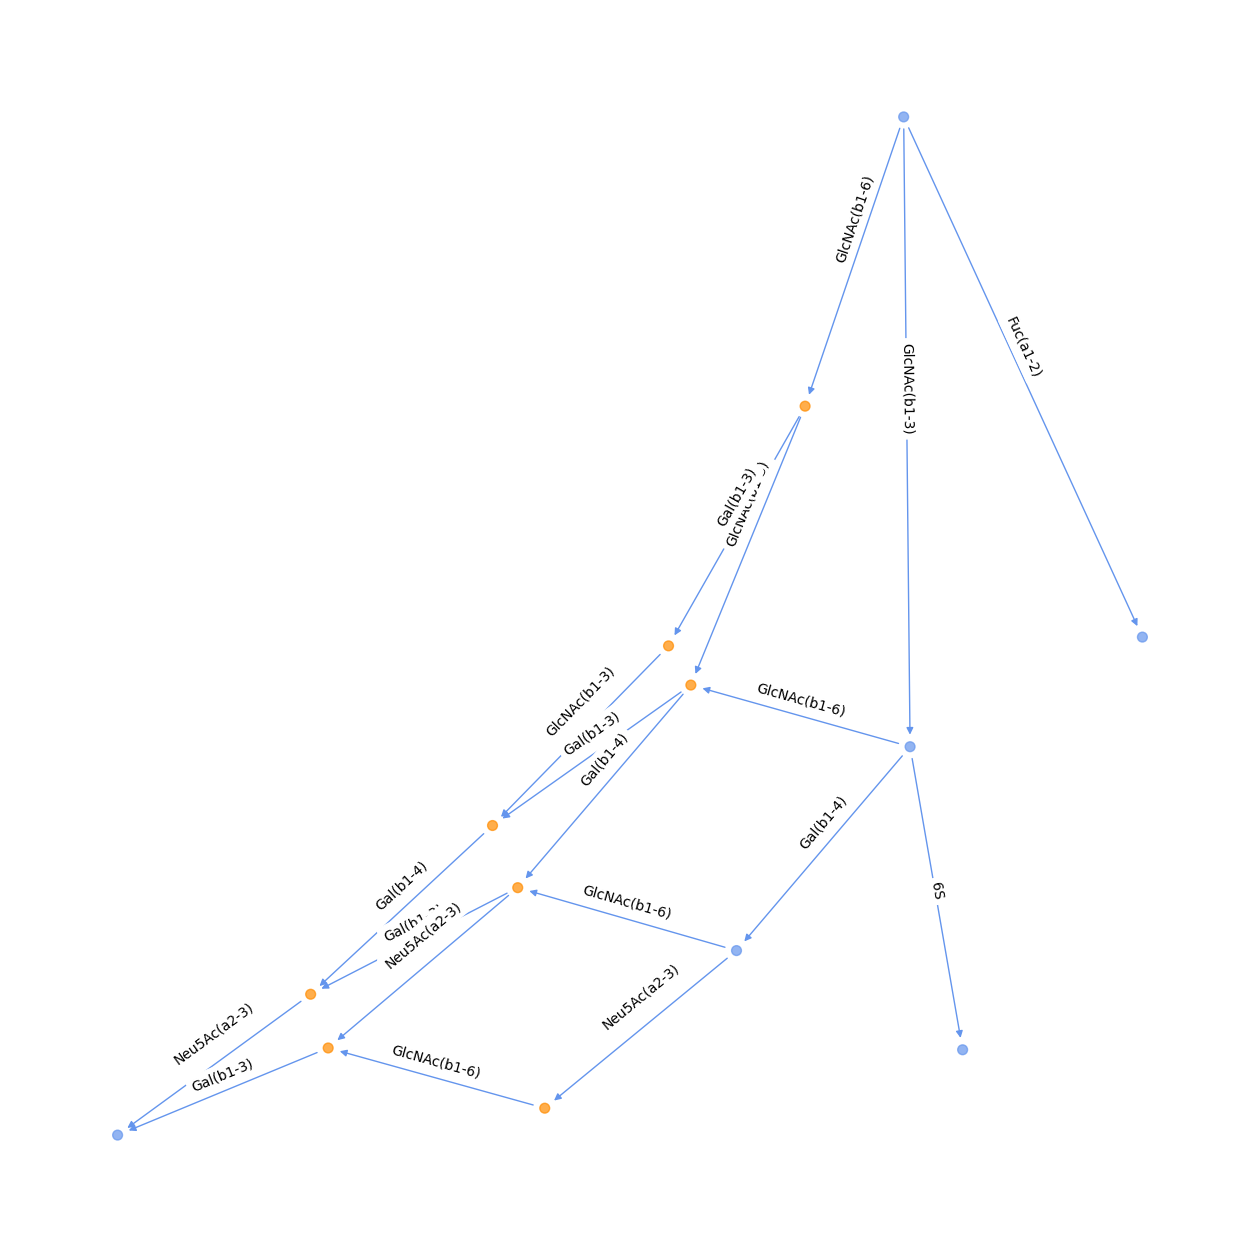

In [ ]:
glycans = ["Gal(b1-4)Glc-ol", "GlcNAc(b1-3)Gal(b1-4)Glc-ol",
           "GlcNAc6S(b1-3)Gal(b1-4)Glc-ol",
           "Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)Glc-ol", "Fuc(a1-2)Gal(b1-4)Glc-ol",
          "Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-3)[Gal(b1-3)GlcNAc(b1-6)]Gal(b1-4)Glc-ol"]
network = construct_network(glycans)
plot_network(network, plot_format = 'kamada_kawai')

We can see that, in these networks, every dot is a glycan (and can be hovered over to see its sequence) and every link is the addition of a monosaccharide in a defined linkage by an enzyme. Blue dots are glycans which we provided as input, orange glycans are inferred in order to connect the network. <br>

One thing you can immediately see is that there often are multiple paths to reach a blue dot, via several orange routes. This is because we don't know the order in which the monosaccharides have been added. We show in recent work that this order is highly conserved. Therefore, we could use knowledge gathered over decades in the breast milk of over a hundred mammalian species, to find out which order is realistic. <br>

`glycowork` can help you here as well, since it contains pre-computed biosynthetic networks for milk glycans of >100 mammalian species. We can use the `evoprune_network` function to use this information to prune our networks, removing paths that are evolutionarily very unlikely.

19
11


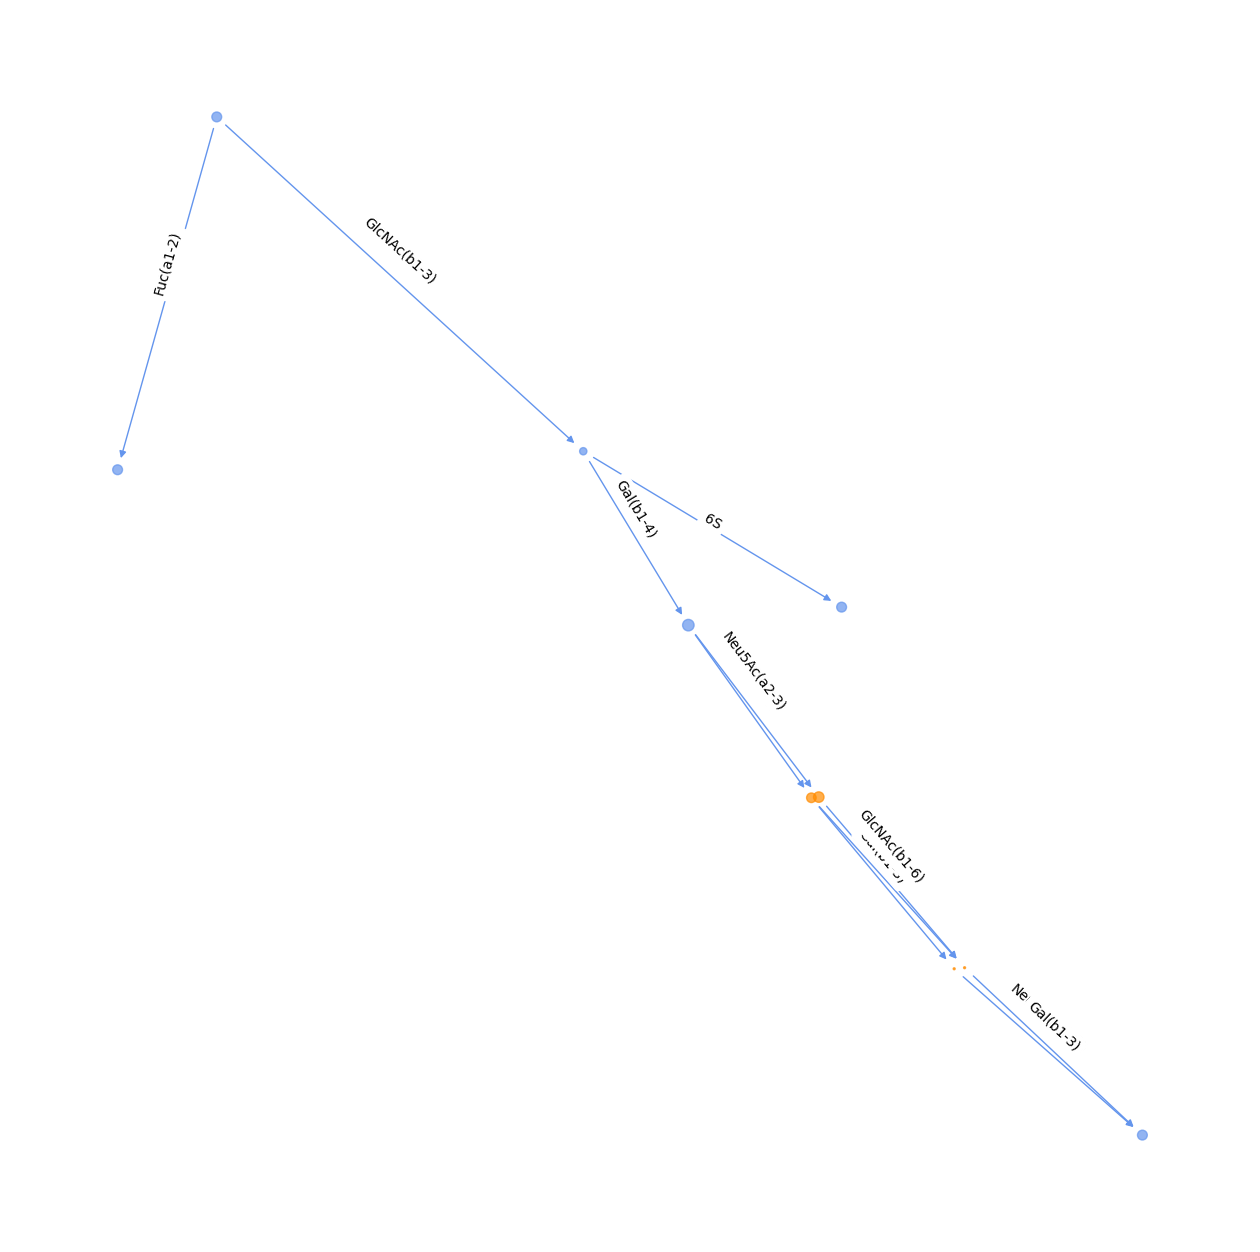

In [ ]:
print(len(network.edges()))
network = evoprune_network(network)
print(len(network.edges()))
plot_network(network, plot_format = 'kamada_kawai')

Nice, that's a bit more organized! `evoprune_network` has removed a few of the nodes that had zero probability. You can see that the orange nodes have changed size as well. This is to indicate their probability. If you change the `threshold` parameter of `evoprune_network` these low-probability nodes might also be pruned away, yet network connectivity is always preserved. <br>

Now, let's say we want to highlight parts of the network containing the monosaccharide Neu5Ac. For this, we can use `highlight_network`. With this function, you can highlight many things in a network: motifs, abundances, species occurence, evolutionary conservation, etc.

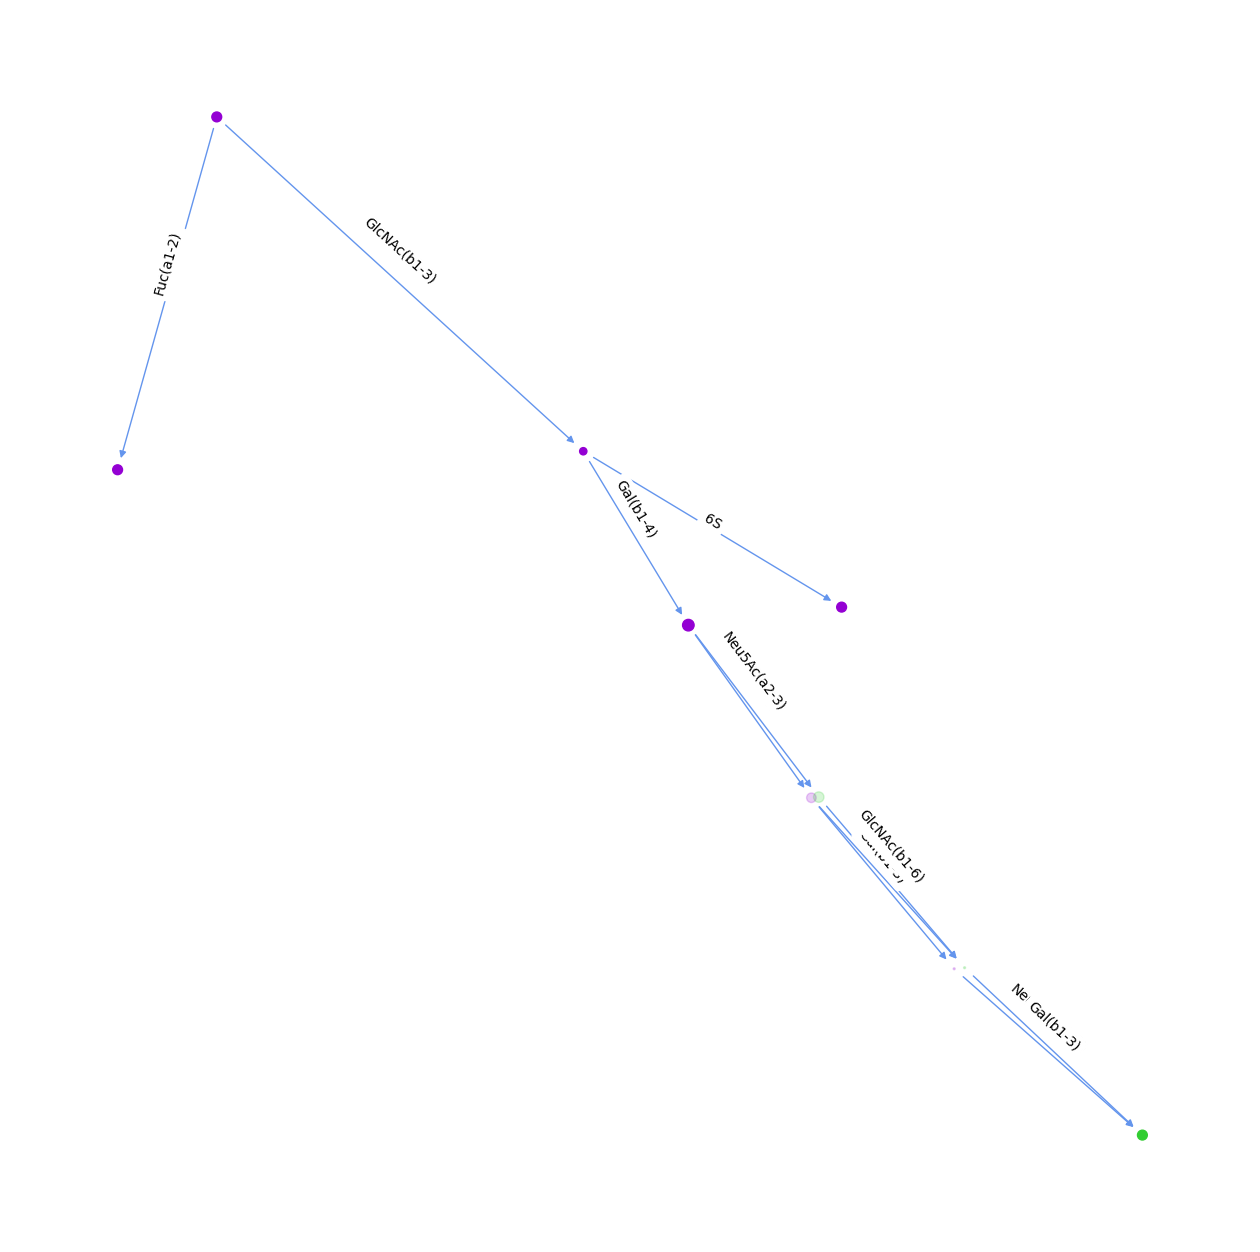

In [ ]:
network = highlight_network(network, 'motif', motif = 'Neu5Ac')
plot_network(network, plot_format = 'kamada_kawai')

You can see that the node color has changed now. Every glycan/node that contains Neu5Ac now is showing up as a green node, while those lacking Neu5Ac are purple. You can also still make out which nodes are inferred (transparent) and actually observed (solid). The probabilities from `evoprune_network`are also still contained within the network. Apart from these visualizations, you can use these networks for all kinds of analytical work, from `motif.graph.generate_graph_features` to `network.evolution.get_communities`; your only limitation is your creativity!:-)

We can also use the functions within `glycowork.network` to compare species and their milk glycomes:
Let's have a look at the two pre-computed biosynthetic networks (found in net_dic) of black bears (Ursus americanus) and brown bears (Ursus arctos).

pydot2 threw an error (maybe you're using Windows?); we'll use kamada_kawai instead


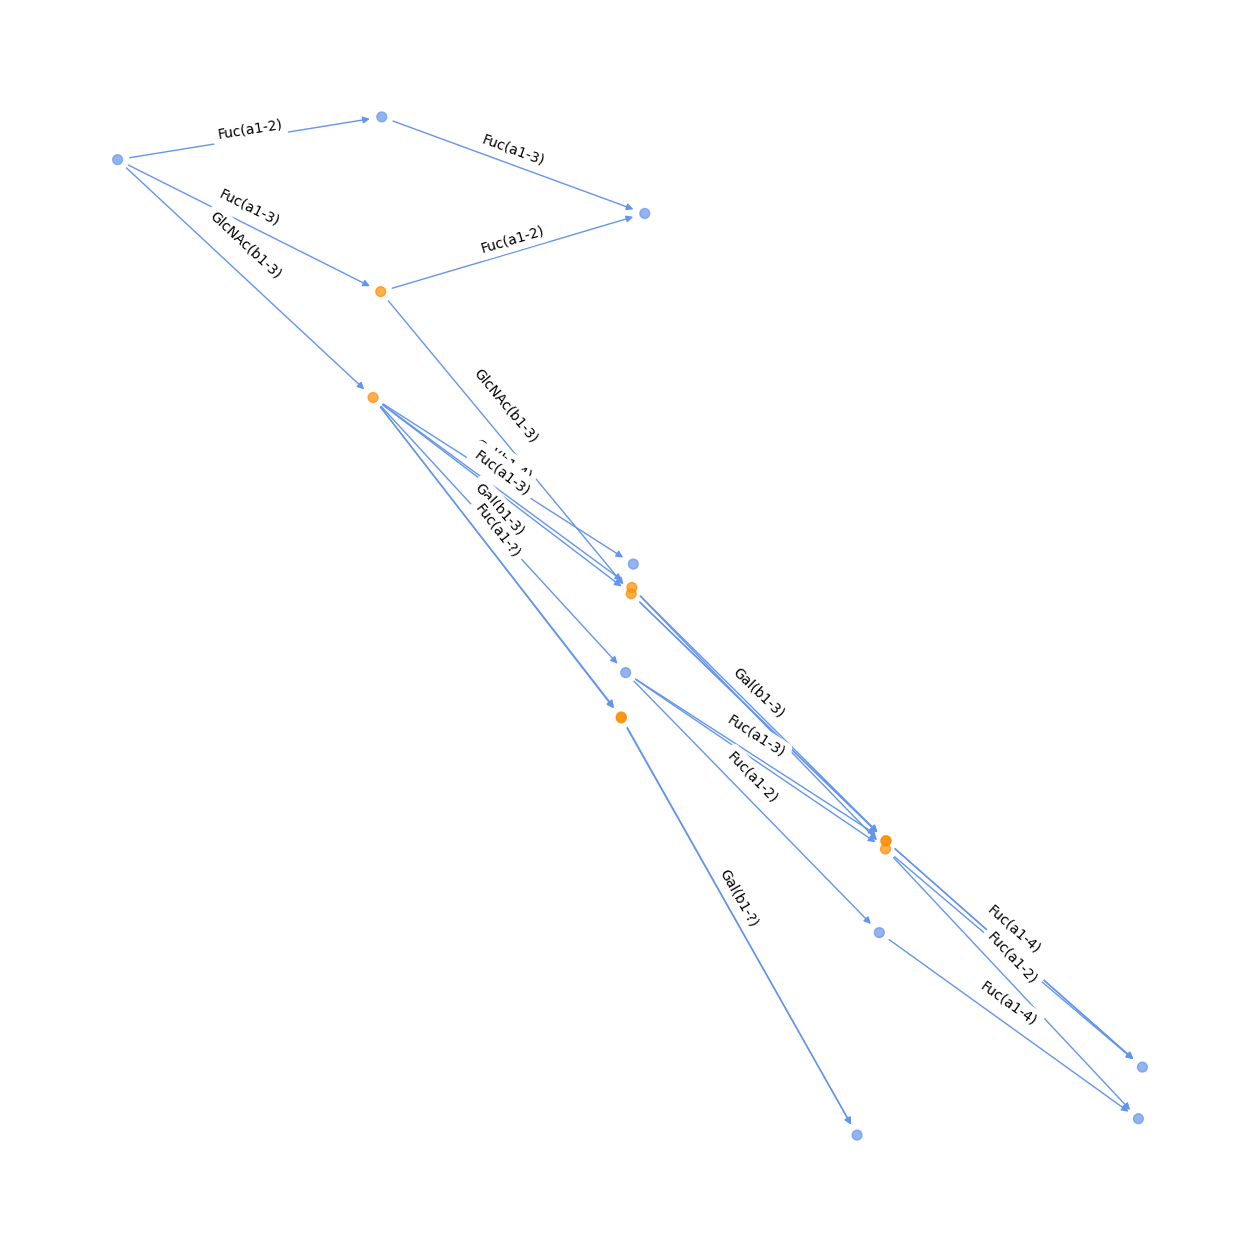

In [ ]:
blackbear_network = net_dic['Ursus_americanus']
brownbear_network = net_dic['Ursus_arctos']
plot_network(network = brownbear_network)

As in our example we have two networks, it is possible to directly combine and compare them to identify conserved and specific nodes, using for instance `network_alignment`.

pydot2 threw an error (maybe you're using Windows?); we'll use kamada_kawai instead


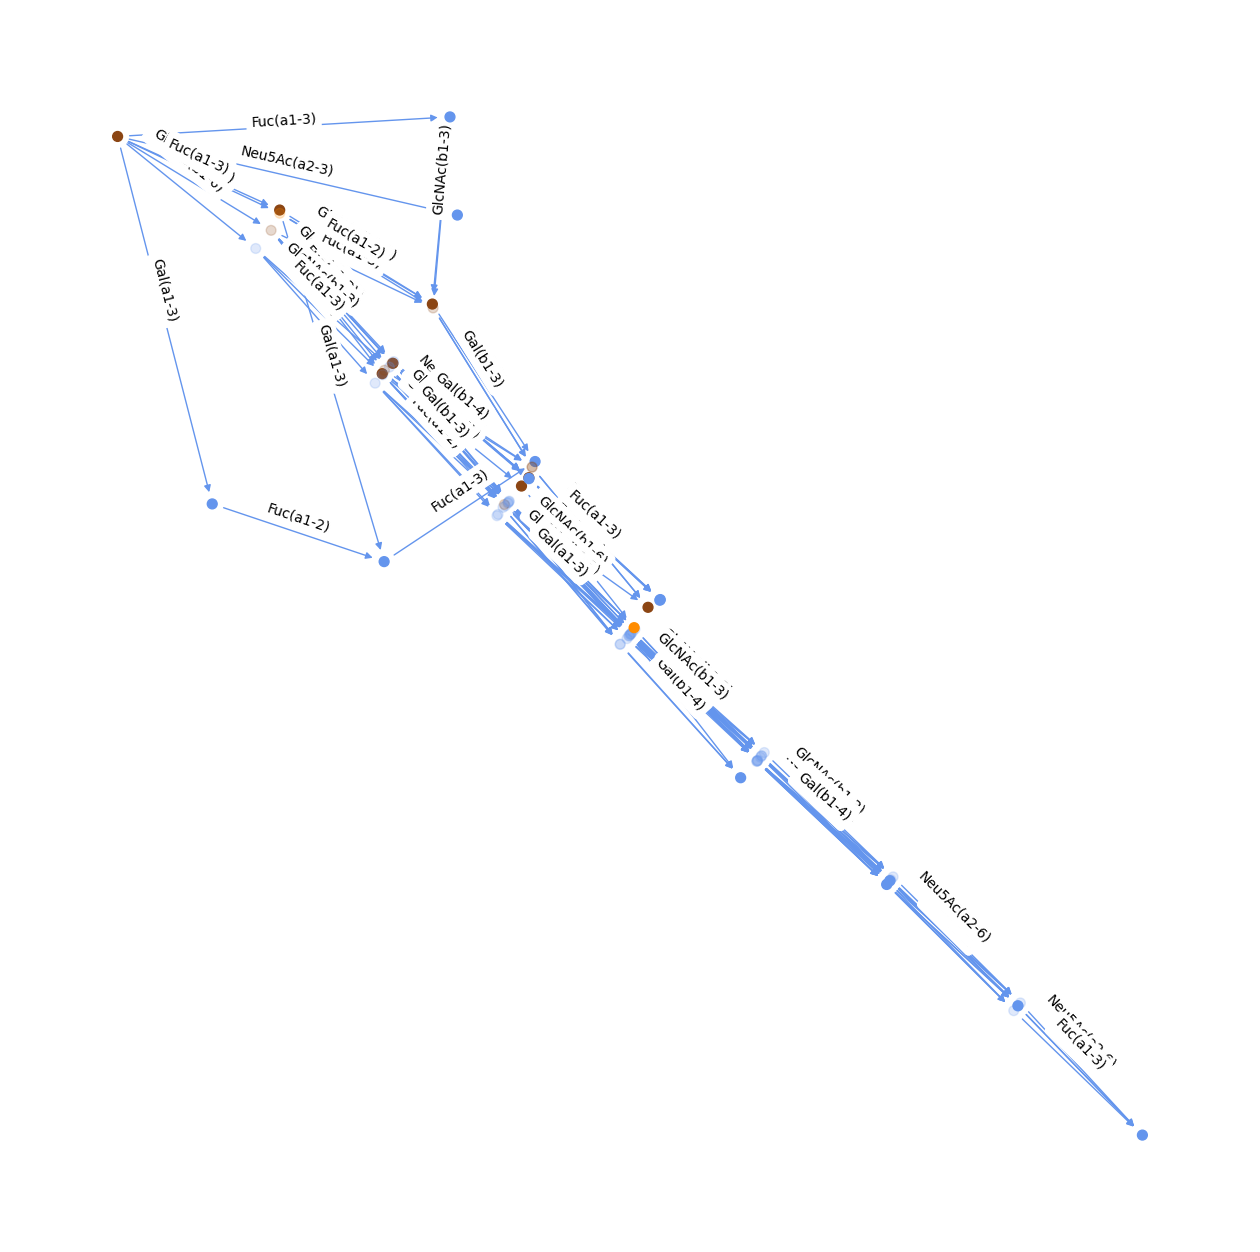

In [ ]:
combined_network = network_alignment(network_a = blackbear_network, network_b = brownbear_network)
plot_network(network = combined_network)

In this new representation, the blue nodes are specific to network_a (here the black bear), and orange nodes are specific to network_b (the brown bear). The remaining brown nodes are conserved in both species. Virtual nodes follow the same color scheme but are transparent. Here, we can see many blue nodes that are specific to the black bear. This is not so surprising, as the black bear network is larger.  

We can also make use of the `network.evolution` module to compare the similarity of related species, such as different kinds of bears. Using the metric of Jaccard distance between their networks, we can retrieve sequences and networks for various bear species within `glycowork` with the function `distance_from_metric`. Then, we can use the distance matrix in the `dendrogram_from_distance` function to plot the resulting clustering. One immediate result here is that polar bears (Ursus maritimus) seem to have a very different milk glycome from other types of bears!

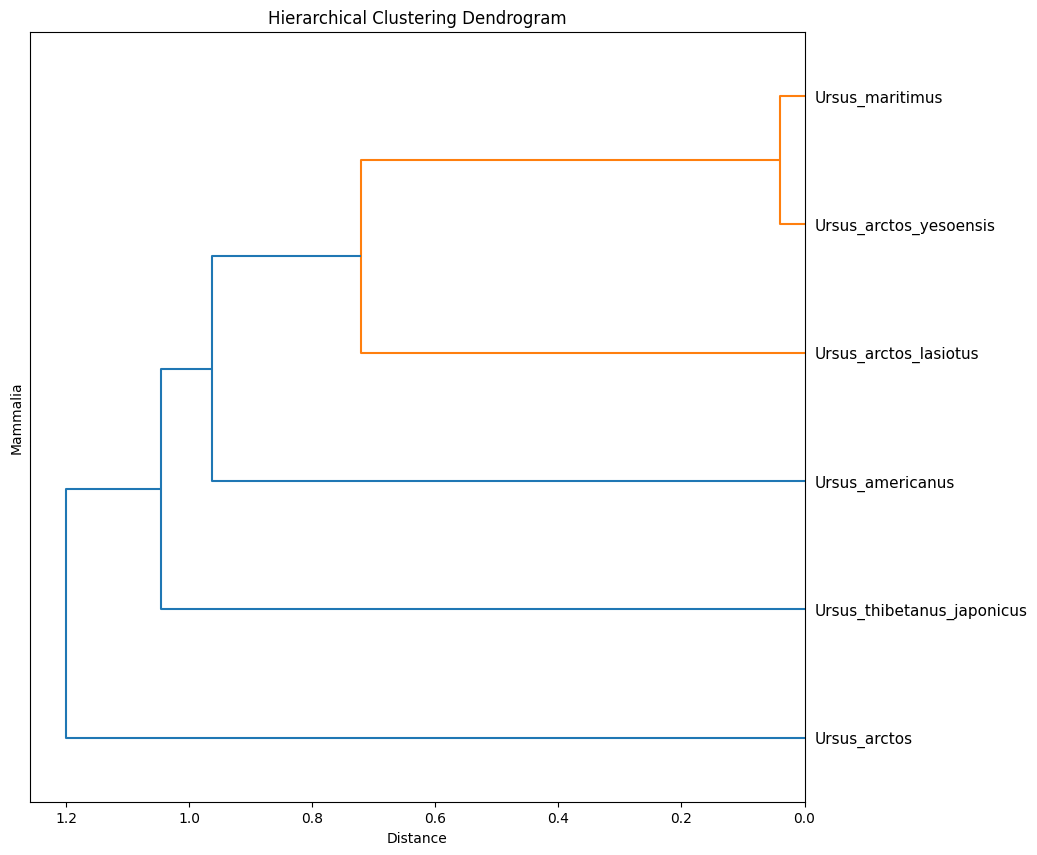

In [ ]:
bears = [net_dic[k] for k in list(set(list(net_dic.keys()))) if 'Ursus' in k]
df_bears = df_species[df_species.Genus=='Ursus'].reset_index(drop = True)
dm = distance_from_metric(df_bears, bears, cut_off = 5)
dendrogram_from_distance(dm)

In [ ]:
#| echo: false
dm.index = dm.columns.tolist()
HTML(dm.style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica','border-collapse': 'collapse','border': '1px solid black'}).render())

,Ursus_americanus,Ursus_arctos,Ursus_arctos_lasiotus,Ursus_arctos_yesoensis,Ursus_maritimus,Ursus_thibetanus_japonicus
Ursus_americanus,0.000000,0.958333,0.636986,0.668831,0.655844,0.725000
Ursus_arctos,0.958333,0.000000,0.910256,0.954023,0.955056,0.783784
Ursus_arctos_lasiotus,0.636986,0.910256,0.000000,0.426966,0.422222,0.712963
Ursus_arctos_yesoensis,0.668831,0.954023,0.426966,0.000000,0.026667,0.716814
Ursus_maritimus,0.655844,0.955056,0.422222,0.026667,0.000000,0.710526
Ursus_thibetanus_japonicus,0.725000,0.783784,0.712963,0.716814,0.710526,0.000000


# Deep Learning Code Snippets <a class="anchor" id="example5"></a>

For those of you that are blessed with GPU-access, we wrote up a minimal example for training a glycan-focused deep learning model. Even if you usually do not have access to a GPU, you can always go to Google Colab (click on the badge at the top of this site to open this notebook on Google Colab) and change the runtime type to GPU. Then you can paste the following code in a cell, execute, and see our model train!

First, we need to install torch_geometric for deep learning (keep the package versions; especially if you want to use our trained models):

```
!pip install torch==2.0
!pip install torch-geometric==2.3.0
```

*SweetNet-type model*

Then, we import the relevant `glycowork` modules:

```
from glycowork.glycan_data.loader import df_species
from glycowork.ml.train_test_split import hierarchy_filter
from glycowork.ml.processing import split_data_to_train
from glycowork.ml import models
from glycowork.ml import model_training
```

Finally, we can prepare the data and train a model to classify from which taxonomic kingdom a glycan came from, using our graph convolutional neural network, `SweetNet`.

```
train_x, val_x, train_y, val_y, id_val, class_list, class_converter = hierarchy_filter(df_species,
                                                                                       rank = 'Kingdom')

dataloaders = split_data_to_train(train_x, val_x, train_y, val_y)
model = models.prep_model('SweetNet', len(class_list))
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.0005)
model_ft = model_training.train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100)
```

And that's it! You've just trained a state-of-the-art deep learning model with effectively five lines of code (excluding package imports of course).

*LectinOracle-type model*

For `LectinOracle`, you need a protein sequence and glycan sequences. Further, you will need to retrieve the ESM1b-representation for your protein sequence, as that is used as the actual input for LectinOracle. If you don't want to do that, check below for the `LectinOracle_flex` model. Here the minimal process is shown for the arbitrary protein sequence "QWERTFVCF". The trained model is yet again retrieved via `prep_model`.

```
!pip install fair-esm
import esm
from glycowork.ml.inference import get_esm1b_representations, get_lectin_preds
from glycowork.ml.models import prep_model

model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
rep = get_esm1b_representations(["QWERTFVCF"], model, alphabet)
leor = prep_model("LectinOracle", 1, trained = True)
get_lectin_preds("QWERTFVCF", ['Neu5Ac(a2-6)GalNAc', 'Gal(b1-4)Glc'], leor, rep)
```

The output here (same as for `LectinOracle_flex` below) is a table/dataframe, where each row shows the tested glycan and its associated binding prediction. The higher the binding prediction, the more likely an interaction (negative values in general likely mean "no interaction"), with a moderate correlation with binding affinity (based on our findings so far).

*LectinOracle_flex-type model*

While it has a slightly lower performance than `LectinOracle`, `LectinOracle_flex` can directly use protein sequences as input (no ESM1b-conversion necessary). This is made possible by knowledge distillation, in which we train a sub-module to mimic the conversion of the much larger ESM1b model. Just get the correct model via `prep_model` and declare `flex = True` and you're good to go!

```
from glycowork.ml.inference import get_lectin_preds
from glycowork.ml.models import prep_model
leor = prep_model("LectinOracle_flex", 1, trained = True)
get_lectin_preds("QWERTFVCF", ['Neu5Ac(a2-6)GalNAc', 'Gal(b1-4)Glc'], leor, flex = True)
````